In [1]:
import sqlite3
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7.5) # Increase default figure size 

In [2]:
# Provided test function
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"

team_salaries = pd.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


## Part 1: Wrangling

#### Problem 1

In [31]:
query = """
SELECT * 
FROM Salaries 
WHERE salary IS NULL or teamID IS NULL or yearID IS NULL
"""

team_payrolls = pd.read_sql(query, conn)
team_payrolls.head()

,yearID,teamID,lgID,playerID,salary


In [30]:
query = """
SELECT * 
FROM Teams 
WHERE W IS NULL or G IS NULL or franchID IS NULL or teamID IS NULL or yearID IS NULL
"""

team_payrolls = pd.read_sql(query, conn)
team_payrolls.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro


There are no entries in either of the relevant tables (Salaries and Teams) where any of the included data is NULL, so the way that we deal with null data is irrelevant.  

In [25]:
# By doing an inner join, I remove all the rows in the tables which don't have a team ID or yearID
# in either one of the tables. If a person in the Salaries table does not have a salary associated,
# they will not be included in the payroll calculation (as if they did not play on the team). Other
# null data will be parsed as NaN by sqlite3, I believe.

query = """
WITH Payrolls AS (
    SELECT teamID, yearID, sum(salary) as totalPayroll 
    FROM Salaries 
    GROUP BY teamID, yearID
)
SELECT yearID, teamID, franchID, totalPayroll, G, W, CAST(W as REAL) / G * 100 as winPercentage
FROM Payrolls NATURAL INNER JOIN Teams
"""
team_payrolls = pd.read_sql(query, conn)
team_payrolls.head()

,yearID,teamID,franchID,totalPayroll,G,W,winPercentage
0,1985,ATL,ATL,14807000.0,162,66,40.740741
1,1985,BAL,BAL,11560712.0,161,83,51.552795
2,1985,BOS,BOS,10897560.0,163,81,49.693252
3,1985,CAL,ANA,14427894.0,162,90,55.555556
4,1985,CHA,CHW,9846178.0,163,85,52.147239


## Part 2: Exploratory Data Analysis

#### Problem 2

In [4]:
payrolls_range = team_payrolls[team_payrolls["yearID"] >= 1990].copy()
print(payrolls_range)

     yearID teamID franchID  totalPayroll    G   W  winPercentage
130    1990    ATL      ATL    14555501.0  162  65      40.123457
131    1990    BAL      BAL     9680084.0  161  76      47.204969
132    1990    BOS      BOS    20558333.0  162  88      54.320988
133    1990    CAL      ANA    21720000.0  162  80      49.382716
134    1990    CHA      CHW     9491500.0  162  94      58.024691
..      ...    ...      ...           ...  ...  ..            ...
853    2014    SLN      STL   120693000.0  162  90      55.555556
854    2014    TBA      TBD    72689100.0  162  77      47.530864
855    2014    TEX      TEX   112255059.0  162  67      41.358025
856    2014    TOR      TOR   109920100.0  162  83      51.234568
857    2014    WAS      WSN   131983680.0  162  96      59.259259

[728 rows x 7 columns]


Text(0, 0.5, 'Total Payroll ($)')

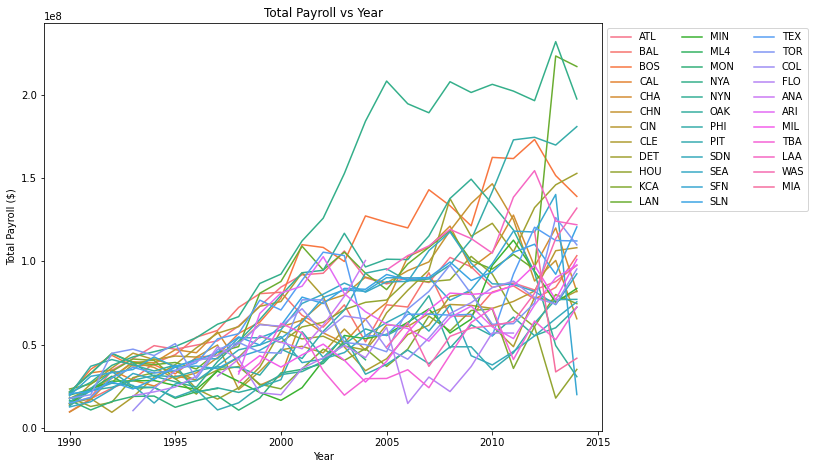

In [5]:
sns.lineplot(x="yearID", y="totalPayroll", data=payrolls_range, hue="teamID")
plt.legend(bbox_to_anchor=[1,1], ncol=3)

# Add labels
plt.title( "Total Payroll vs Year")
plt.xlabel("Year")
plt.ylabel("Total Payroll ($)")

# Note: '$' means USD everywhere it is used in this project.

#### Question 1

The mean payroll for the teams has clearly increased over time, and the spread of the teams payrolls has increased as well. 

#### Problem 3

Text(0, 0.5, 'Mean Payroll ($)')

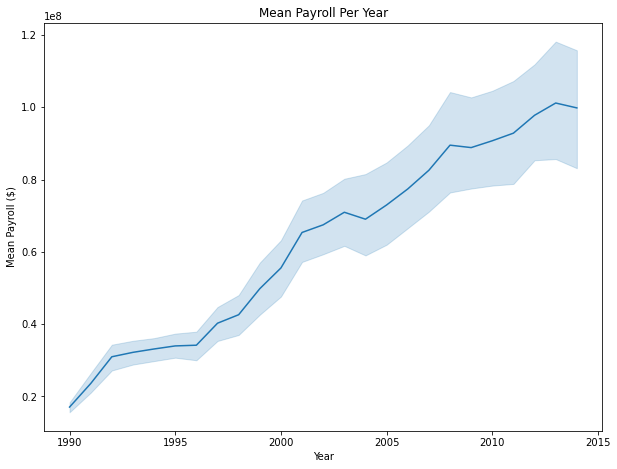

In [6]:
# Show the mean value of payroll over year with 95 percent confidence interval
sns.lineplot(x="yearID", y="totalPayroll", data=payrolls_range)
# Add labels
plt.title("Mean Payroll Per Year")
plt.xlabel("Year")
plt.ylabel("Mean Payroll ($)")

Text(0, 0.5, 'Standard Deviation in Payroll ($)')

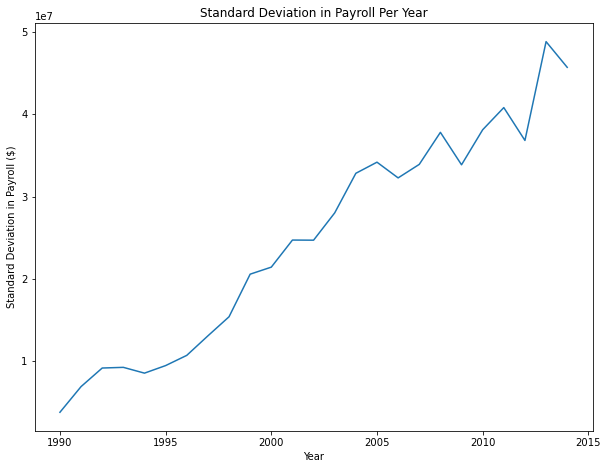

In [7]:
# Show standard deviation of payroll over time
payrolls_by_year = payrolls_range.groupby("yearID")
payrolls_range_years = payrolls_by_year.groups.keys()
plt.plot(payrolls_range_years,payrolls_by_year.std().totalPayroll)
# Add labels
plt.title("Standard Deviation in Payroll Per Year")
plt.xlabel("Year")
plt.ylabel("Standard Deviation in Payroll ($)")

#### Problem 4

Text(0, 0.5, 'Mean Payroll ($)')

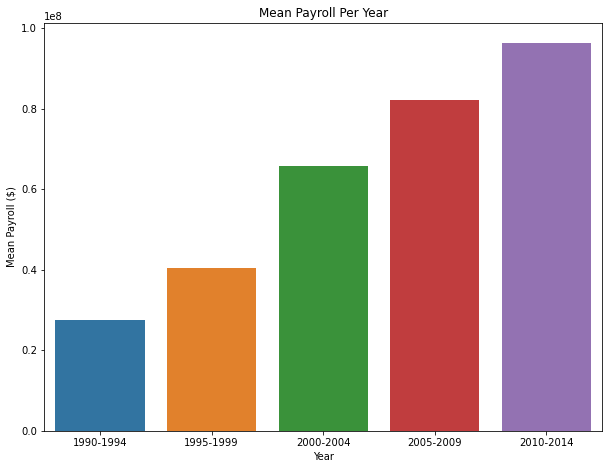

In [8]:
# Split the data into bins of 5 years each
payrolls_bins = np.array_split(list(range(1990,2015)), 5)
year_labels = ["1990-1994", "1995-1999", "2000-2004", "2005-2009", "2010-2014"]
payrolls_binned = [payrolls_range[payrolls_range.yearID.isin(x)] for x in payrolls_bins]

# Plot mean payroll over time
plt.subplot(1,1,1)
sns.barplot(x=year_labels,\
         y=[np.mean(x.totalPayroll) for x in payrolls_binned])

# Add labels
plt.title("Mean Payroll Per Year")
plt.xlabel("Year")
plt.ylabel("Mean Payroll ($)")

Text(0, 0.5, 'Win Percentage (%)')

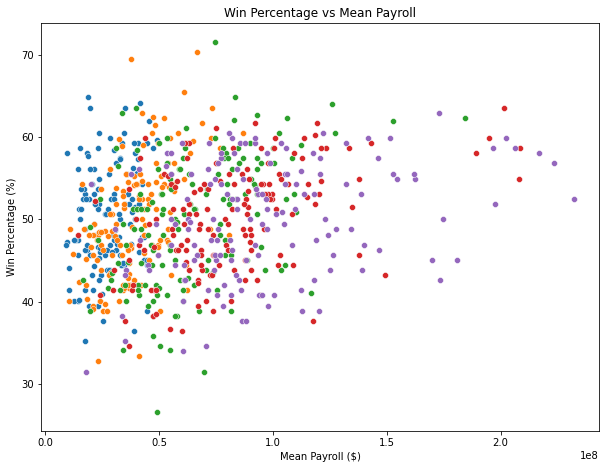

In [9]:
# Plot all points individually, to see the distribution among years
for x in payrolls_binned:
    sns.scatterplot(x=x.totalPayroll,y=x.winPercentage) 

# Add labels
plt.title("Win Percentage vs Mean Payroll")
plt.xlabel("Mean Payroll ($)")
plt.ylabel("Win Percentage (%)")

(These don't look very normally distributed to me, which I think makes the standardization we do later not make a lot of sense, but whatever.)

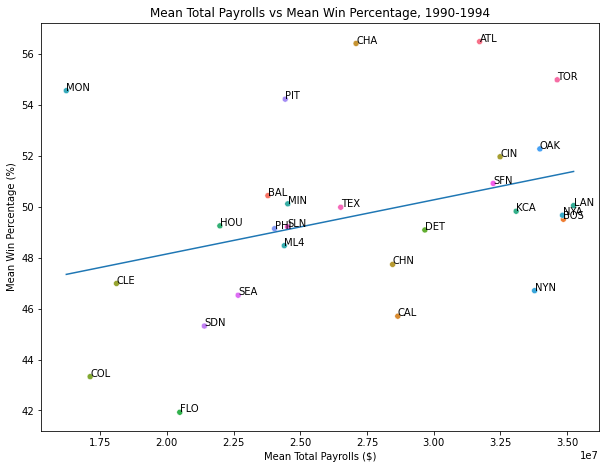

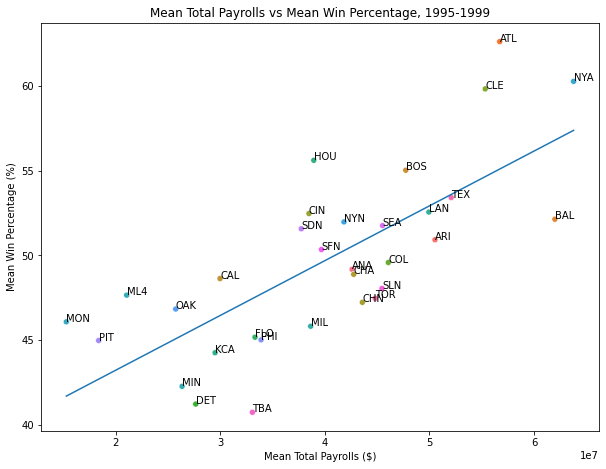

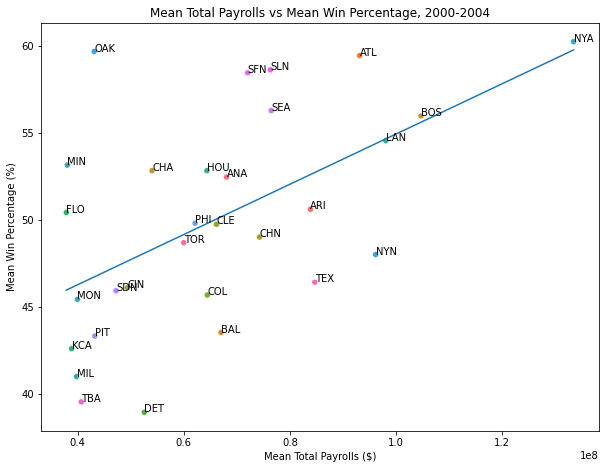

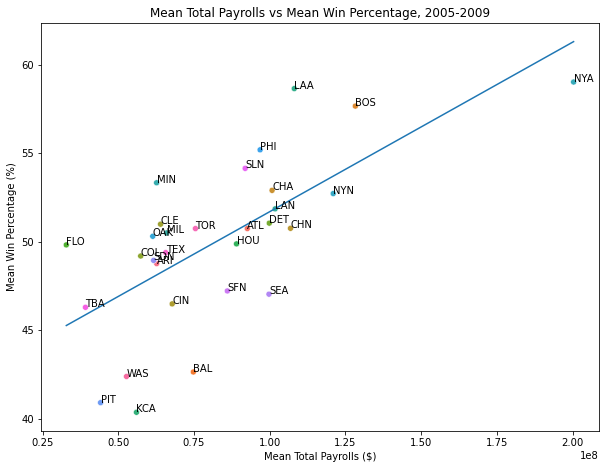

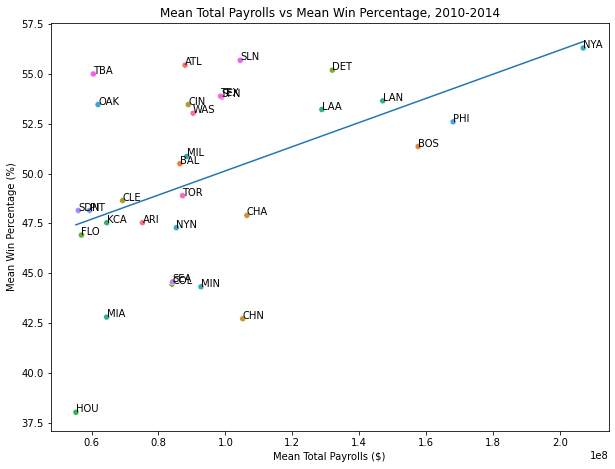

In [10]:
for (year_label, pr) in zip(year_labels, payrolls_binned):
    plt.figure()
    # Get aggregate wins, salary for each team
    # Note: this calculation of win percentage isn't completely accurate,
    # since it is taking the average of the average per year, which doesn't
    # take into account the number of games played per year. For example, if one 
    # season a team wins 1/1 games, then another they win 0/100, this metric would
    # say that they have an average win percentage of 0.5 when it actually should
    # be less than one percent. However, the number of games played per season
    # actually varies very little between years, so this has only a minor effect
    # on the win percentages -- usually the order of hundredths of a percent. 
    # The code showing this is included below this block.
    # I tried to implement this, but I was getting weird technical issues as a 
    # result, so I resorted to the slightly less accurate method.
    payrolls_per_team = pr.groupby("teamID").mean().reset_index()
    x = payrolls_per_team["totalPayroll"]
    y = payrolls_per_team["winPercentage"]
    sns.scatterplot(x="totalPayroll", y="winPercentage", hue="teamID", \
                    data=payrolls_per_team, legend=False)
    
    # Add labels
    plt.title(f"Mean Total Payrolls vs Mean Win Percentage, {year_label}")
    plt.xlabel("Mean Total Payrolls ($)")
    plt.ylabel("Mean Win Percentage (%)")
    
    # Add team labels
    for (i, row) in payrolls_per_team.iterrows():
        plt.annotate(row.teamID, (row.totalPayroll, row.winPercentage))
    
    # Plot line of best fit
    p = np.poly1d(np.polyfit(x, y, 1))
    plt.plot([min(x),max(x)], [p(min(x)), p(max(x))])
    
    

In [11]:
# Showing that average of win rates per year is approximately the same as the actual win rate over the interval
# (See above code block for context)
for a in payrolls_binned:
    # Get aggregate wins, salary for each team
    dfg = a.groupby("teamID").agg(["sum","mean"]).reset_index()
    x = dfg["totalPayroll"]["mean"]
    dfg["avgWinPercentage"] = dfg.apply(lambda e: e["W"]["sum"] / e["G"]["sum"] * 100, axis=1)
    
    print(dfg[["teamID", "avgWinPercentage", "winPercentage"]].head())

  teamID avgWinPercentage winPercentage           
                                    sum       mean
0    ATL        56.299213    282.488629  56.497726
1    BAL        50.065876    252.220401  50.444080
2    BOS        49.672346    247.573806  49.514761
3    CAL        46.002621    228.523886  45.704777
4    CHA        56.241787    282.131542  56.426308
  teamID avgWinPercentage winPercentage           
                                    sum       mean
0    ANA        49.176955    147.530864  49.176955
1    ARI        50.925926    101.851852  50.925926
2    ATL        62.626263    313.117284  62.623457
3    BAL        52.206810    260.700693  52.140139
4    BOS        54.924242    275.154321  55.030864
  teamID avgWinPercentage winPercentage           
                                    sum       mean
0    ANA        52.469136    262.345679  52.469136
1    ARI        50.617284    253.086420  50.617284
2    ATL        59.456119    297.300820  59.460164
3    BAL        43.526510    21

#### Question 2

In each interval, there is a broadly positive correlation between the total payroll and the win percentage of a team, though the correlation appears quite weak. In particular, the correlation in the interval from 1990 to 1994 appears close to zero. In this interval, MON (The Montreal Expos) had a winning percentage meaningfully higher than one would predict based on their total payroll, in addition to CHA (Chicago White Sox) to a lesser extent. 
However, the team which appears to be the biggest outlier in thsi regard are the Oakland Athletics from 2000 to 2004. While they spent less than 5 dollars each year, their average win percentage was around 60 percent -- which is what we would predict for a team spending nearly 15 million dollars per year. 
If we look at the cost divided by win percentage for each team over these 5 years:

In [12]:
query = """
WITH Payrolls AS (
    SELECT teamID, yearID, sum(salary) as totalPayroll 
    FROM Salaries 
    GROUP BY teamID, yearID
)
SELECT teamID, avg(totalPayroll / (CAST(W as REAL) / G * 100)) as costPerWinPercent
FROM Payrolls NATURAL INNER JOIN Teams
WHERE 2000 < yearID AND yearID < 2004
GROUP BY teamID
"""
payrolls_efficiency_2000_2004 = pd.read_sql(query, conn)
payrolls_efficiency_2000_2004.sort_values("costPerWinPercent").head()

,teamID,costPerWinPercent
20,OAK,671445.863757
16,MIN,717121.683354
11,FLO,834492.865516
17,MON,868777.191708
13,KCA,969483.540913


We can see from the above data that the Oakland Athletics spent significantly less relative to their win percentage than any other team. 
This is only a brief anomaly, however. If plot only the Athletics' payrolls and win percentages on the same graph:

Text(0, 0.5, 'Mean Win Percentage (%)')

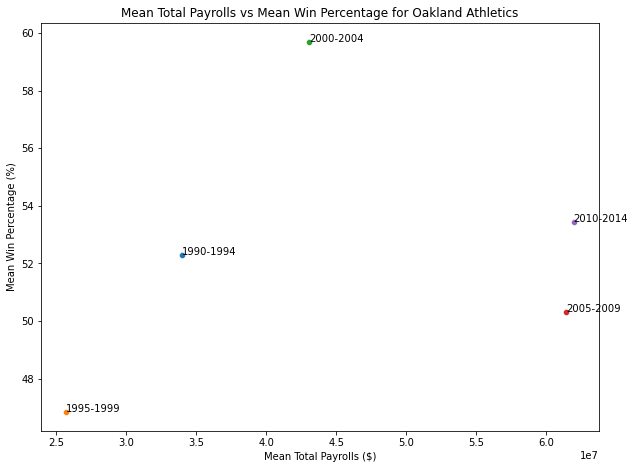

In [13]:
for (year_label, pr) in zip(year_labels, payrolls_binned):
    payrolls_per_team = pr.groupby("teamID").mean().reset_index()
    payrolls_oak = payrolls_per_team[payrolls_per_team["teamID"] == "OAK"]
    sns.scatterplot(x="totalPayroll", y="winPercentage", data=payrolls_oak)
    plt.annotate(year_label, (payrolls_oak["totalPayroll"], payrolls_oak["winPercentage"]))
plt.title( "Mean Total Payrolls vs Mean Win Percentage for Oakland Athletics")
plt.xlabel("Mean Total Payrolls ($)")
plt.ylabel("Mean Win Percentage (%)")

We see that while they spent more money in subsequent years, they never reached the same win percentage they got between 2000 and 2004.

## Part 3: Data Transformations 

#### Problem 5

In [14]:
# Standardize payroll cost over each year
payrolls_mean_std = payrolls_range.groupby("yearID")["totalPayroll"].agg(["mean", "std"])
payrolls_range["standardizedPayroll"] = \
    payrolls_range.apply( lambda x: \
        (x["totalPayroll"] - payrolls_mean_std["mean"][x["yearID"]]) / \
        payrolls_mean_std["std"][x["yearID"]], axis=1)

# Re-do the splitting for the payroll bins per 5 years
payrolls_bins = np.array_split(list(range(1990,2015)), 5)
payrolls_binned = [payrolls_range[payrolls_range.yearID.isin(x)] for x in payrolls_bins]
[x.head() for x in payrolls_binned]

[     yearID teamID franchID  totalPayroll    G   W  winPercentage  \
 130    1990    ATL      ATL    14555501.0  162  65      40.123457   
 131    1990    BAL      BAL     9680084.0  161  76      47.204969   
 132    1990    BOS      BOS    20558333.0  162  88      54.320988   
 133    1990    CAL      ANA    21720000.0  162  80      49.382716   
 134    1990    CHA      CHW     9491500.0  162  94      58.024691   
 
      standardizedPayroll  
 130            -0.667275  
 131            -1.959861  
 132             0.924213  
 133             1.232198  
 134            -2.009859  ,
      yearID teamID franchID  totalPayroll    G   W  winPercentage  \
 264    1995    ATL      ATL    47235445.0  144  90      62.500000   
 265    1995    BAL      BAL    43942521.0  144  71      49.305556   
 266    1995    BOS      BOS    32455518.0  144  86      59.722222   
 267    1995    CAL      ANA    31223171.0  145  78      53.793103   
 268    1995    CHA      CHW    46961282.0  145  68      46

#### Problem 6

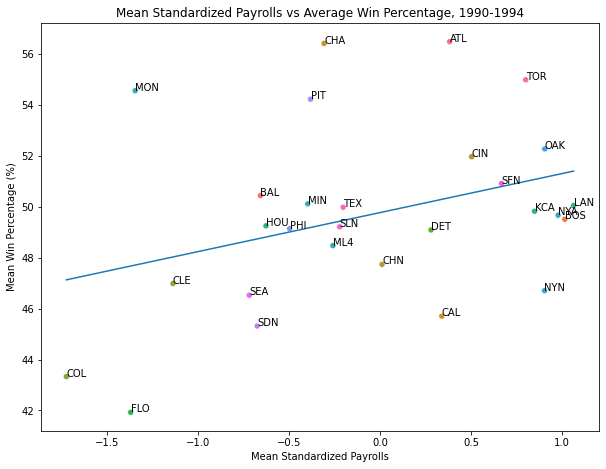

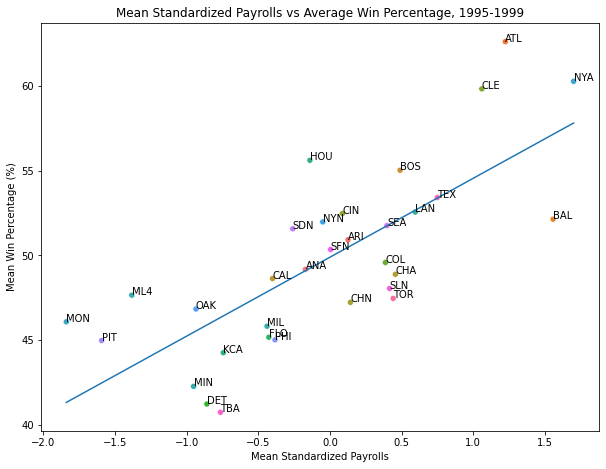

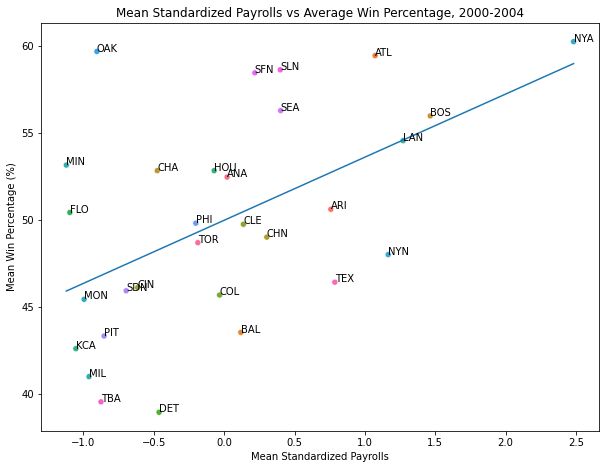

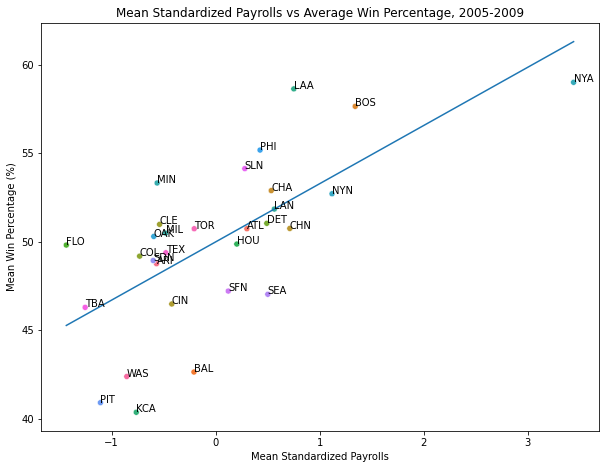

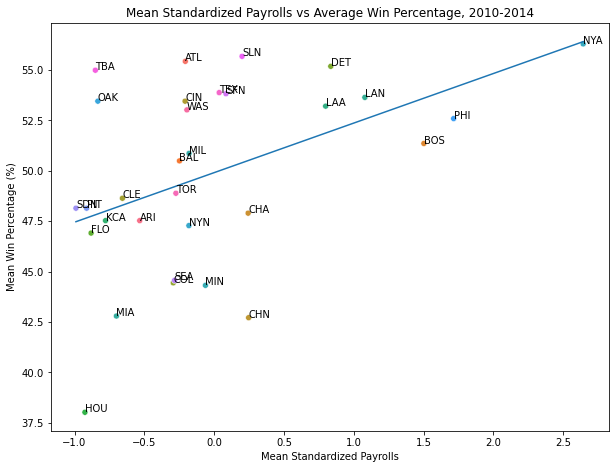

In [15]:
for (year_label, pr) in zip(year_labels, payrolls_binned):
    plt.figure()
    # Get aggregate wins, salary for each team
    # (See note from Problem 4)
    payrolls_per_team = pr.groupby("teamID").mean().reset_index()
    sns.scatterplot(x="standardizedPayroll", y="winPercentage", hue="teamID", \
                    data=payrolls_per_team, legend=False)
    
    # Add labels
    plt.title(f"Mean Standardized Payrolls vs Average Win Percentage, {year_label}")
    plt.xlabel("Mean Standardized Payrolls")
    plt.ylabel("Mean Win Percentage (%)")
    
    # Add team labels
    for (i, row) in payrolls_per_team.iterrows():
        plt.annotate(row.teamID, (row.standardizedPayroll, row.winPercentage))
    
    # Plot line of best fit
    x = payrolls_per_team["standardizedPayroll"]
    y = payrolls_per_team["winPercentage"]
    p = np.poly1d(np.polyfit(x, y, 1))
    plt.plot([min(x),max(x)], [p(min(x)), p(max(x))])
    
    
    

#### Question 3

Overall, the plots for Problem 6 appears very similar in shape to the plots generated for Problem 4, with a weak positive correlation between (standardized) payroll and win percentage. However, instead of the x axis showing values in the millions or tens of millions of dollars, it now shows the payroll amount standardized against the other payrolls within the year (in this case, roughly between -2.5 and 4). If we assume that the payrolls are distributed normally within a 5-year interval, then the standardization produces a distribution with mean 0 and standard deviation 1. 
However, the location of the points on the plots is almost identical. Because the distributions between adjacent years are very similar, they have very similar means and standard deviations, so standardizing the values for each point for the year is very similar to standardizing against the whole set (which would just scale and shift the plot). The changes don't meaningfully impact the takeways from the plots.

#### Problem 7

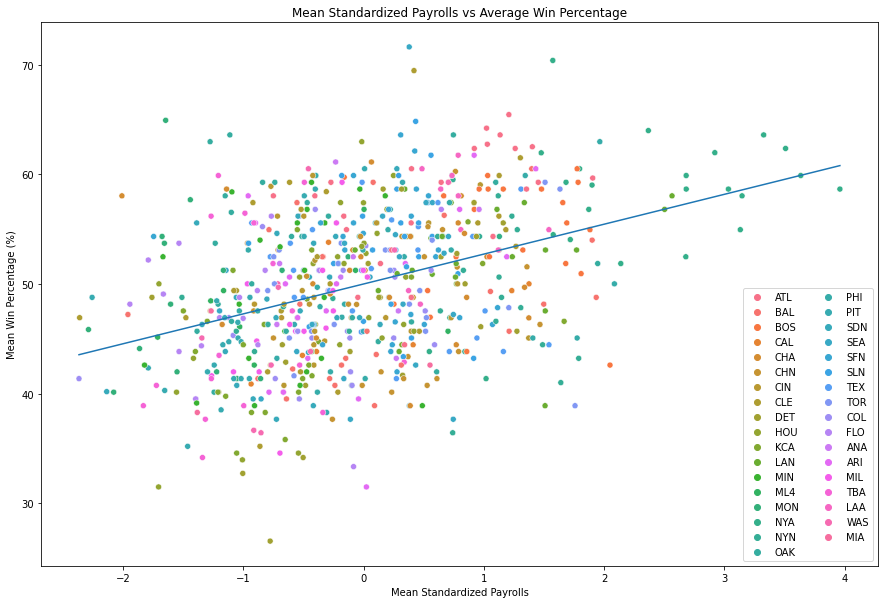

In [16]:
plt.figure(figsize=(15,10))
#Pllot data
x = payrolls_range.standardizedPayroll
y = payrolls_range.winPercentage
sns.scatterplot(x="standardizedPayroll", y="winPercentage", hue="teamID", data=payrolls_range)
plt.legend(loc='lower right', ncol=2)

# Add labels
plt.title( "Mean Standardized Payrolls vs Average Win Percentage")
plt.xlabel("Mean Standardized Payrolls")
plt.ylabel("Mean Win Percentage (%)")

# Plot line of best fit
p = np.poly1d(np.polyfit(x, y, 1))
plt.plot([min(x),max(x)], [p(min(x)), p(max(x))])

#### Problem 8

In [17]:
# Calculate expected win percentage based on the formula given in the README
payrolls_range["expectedWinPercentage"] = 50 + 2.5 * payrolls_range["standardizedPayroll"]
payrolls_range.head()

,yearID,teamID,franchID,totalPayroll,G,W,winPercentage,standardizedPayroll,expectedWinPercentage
130,1990,ATL,ATL,14555501.0,162,65,40.123457,-0.667275,48.331811
131,1990,BAL,BAL,9680084.0,161,76,47.204969,-1.959861,45.100348
132,1990,BOS,BOS,20558333.0,162,88,54.320988,0.924213,52.310533
133,1990,CAL,ANA,21720000.0,162,80,49.382716,1.232198,53.080495
134,1990,CHA,CHW,9491500.0,162,94,58.024691,-2.009859,44.975353


Text(0, 0.5, 'Efficiency (%)')

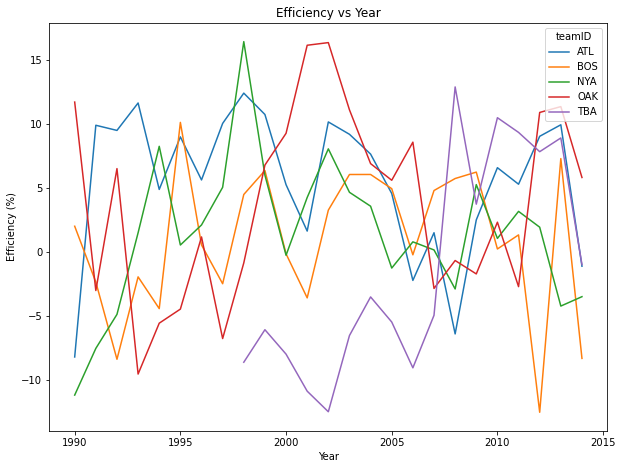

In [18]:
# Record "efficiency" of each team
payrolls_range["efficiency"] = payrolls_range["winPercentage"] - payrolls_range["expectedWinPercentage"]
#payrolls_range.head()

# Make line plot of year versus efficiency for various teams
relevant_teams = ["OAK", "BOS", "NYA", "ATL", "TBA"]
payrolls_relevant_teams = payrolls_range[payrolls_range["teamID"].isin(relevant_teams)]
sns.lineplot(x="yearID", y="efficiency", hue="teamID", data=payrolls_relevant_teams)

# Add labels
plt.title( "Efficiency vs Year")
plt.xlabel("Year")
plt.ylabel("Efficiency (%)")

#### Question 4

This graph allows us to track the efficiencies of individual teams over time, which was much harder to do when we were looking at all of the data point for all of the teams. This data is also plotted over time explicitly, so we can see how teams changed over the years and compare them year to year.
For example, we can see from this plot that the Oakland Athletics' incredible efficiency only lasted for a few years, jumping dramatically in the late 90's and descending back to the average in the mid to late 00's. But in that window of a few years, the Athletics had maximum efficiency over **15**. In other words, their win percentage was over 15% higher than our linear regression predicts, or 15% more than what we would expect if they were average for their payroll class. 

## Extra Credit

In order to get the most recent data, all you need to do is run the following code, which will create a databse file `lehman2020.db` with all of the 2020 data from Lehman's archive. No human intervention is needed. 

In [19]:
import requests, zipfile, os

In [20]:
file_url = "https://github.com/chadwickbureau/baseballdatabank/archive/master.zip"
zip_path = "master.zip"
db_name = "lehman2020.db"
csv_path = "./baseballdatabank-master/core"

In [21]:
# Download the data as comma-separated values in a ZIP from Lehman's website
# (Which I found just by doing a web search) 
r = requests.get(file_url)
with open(zip_path, 'wb') as fd:
    for chunk in r.iter_content(chunk_size=128):
        fd.write(chunk)

In [22]:
# Open and extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")

In [23]:
# Create new database
connection = sqlite3.connect(db_name)

# For every file in the directory...
for filename in os.listdir(csv_path):
    # Get the parts of the file name -- if it's a CSV...
    file_parts = os.path.splitext(filename)
    # If it's a CSV...
    if file_parts[1] == ".csv":
        # Read in CSV into Pandas dataframe
        df = pd.DataFrame(pd.read_csv(csv_path + "/" + filename))  
        # Create a new table with the same name as the file
        # Note: I'm not using prepared statements because who cares
        #cursor = connection.cursor()
        df.to_sql(file_parts[0], connection, if_exists="replace")

In [24]:
# Testing out the new database
team_salaries = pd.read_sql(salary_query, connection)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120
1,1986,157716444
2,1987,136088747
3,1988,157049812
4,1989,188771688
